# Factor Model Construction

This notebook implements **Part 2** of the project requirements:
1.  **Data Setup**: Downloads historical returns for our universe using `yfinance`.
2.  **Factor Estimation**: Uses Cross-Sectional Regression to estimate daily returns for factors like Size, Value, and Momentum.
3.  **Robustness Check**: Compares Ordinary Least Squares (OLS) vs. Huber Robust Regression (as requested in the prompt) to handle outliers.

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# Import custom modules
from adv_hedging.data.loaders import load_risk_factors
from adv_hedging.risk_model.factor_engine import calculate_factor_returns
from adv_hedging.config import PROCESSED_DATA_DIR

# Create processed directory if it doesn't exist
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

plt.style.use('ggplot')
print("Libraries loaded.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Libraries loaded.


## 1. Load Bloomberg Factor Exposures
We load the risk factors (Size, Value, Momentum, Volatility) from the Excel file. These serve as our independent variables ($X$) in the regression equation:
$$R_{stock} = \beta_{size}F_{size} + \beta_{value}F_{value} + ... + \epsilon$$

In [4]:
# Load the raw Excel data
df_factors_raw = load_risk_factors()

# Rename columns to standard names for easier handling
# Based on the specific headers found in your provided '20250928_US_Port.xlsx'
rename_map = {
    'Ticker.1': 'ticker',
    'PORT US Sz Fact Exp:D-1': 'Size',
    'PORT US Val Fact Exp:D-1': 'Value',
    'PORT US Mom Fact Exp:D-1': 'Momentum',
    'PORT US Vol Fact Exp:D-1': 'Volatility',
    'PORT US Prof Fact Exp:D-1': 'Profitability',
    'PORT US Lev Fact Exp:D-1': 'Leverage',
    'PORT US Trd Act Fact Exp:D-1': 'Trading_Activity'
}

# Select only the relevant factor columns
# We use 'Ticker.1' because the first 'Ticker' column in the Excel file often has extra text
factor_cols = list(rename_map.keys())
exposures = df_factors_raw[factor_cols].rename(columns=rename_map).set_index('ticker')

# Drop rows with missing factor data (can't regress on NaNs)
exposures = exposures.dropna()

print(f"Loaded factor exposures for {len(exposures)} tickers.")
exposures.head()

Loaded factor exposures for 664 tickers.


,Size,Value,Momentum,Volatility,Profitability,Leverage,Trading_Activity
ticker,,,,,,,
ZTS US,-1.523572,0.005524,-1.299539,-0.569651,0.566764,0.352002,-0.198326
ZS US,-2.184946,-0.910937,0.937471,-1.758003,-1.937661,0.028424,1.026345
ZM US,-2.095830,0.388688,-0.090163,-0.947485,-0.767941,-1.240460,0.733922
ZION US,-1.876975,1.494906,0.002381,-0.262339,-1.527891,-0.016890,0.677640
ZBH US,-1.860308,0.901767,-0.957841,-0.484387,-1.145859,0.387653,0.271518


## 2. Download Historical Returns (Y-Variable)
We need the dependent variable ($R_{stock}$) for our regression. We will download 2 years of daily returns using `yfinance` for all tickers in our universe.

In [5]:
# 1. clean up tickers (Bloomberg uses " ZTS US", yfinance needs "ZTS")
tickers_list = [t.split()[0] for t in exposures.index]

print(f"Downloading returns for {len(tickers_list)} tickers...")

# Download data (2 years lookback)
# We use auto_adjust=True to handle dividends/splits correctly
price_data = yf.download(
    tickers_list, 
    start="2023-01-01", 
    end="2025-01-01", 
    auto_adjust=True,
    progress=True
)['Close']

# Calculate daily percentage returns
returns_df = price_data.pct_change().dropna(how='all')

# Align the index of exposures to match the columns of returns_df
# (Some tickers might fail to download or have changed symbols)
common_tickers = returns_df.columns.intersection(tickers_list)

# Map back to the Bloomberg index format if necessary, or just re-index exposures
# Simplest approach: Update exposures index to match the clean yfinance tickers
exposures.index = [t.split()[0] for t in exposures.index]
exposures = exposures.loc[common_tickers]
returns_df = returns_df[common_tickers]

print(f"Data Aligned. Final Universe Size: {len(common_tickers)} stocks.")
print(f"Returns Shape: {returns_df.shape}")

[                       1%                       ]  8 of 664 completed$SFD: possibly delisted; no price data found  (1d 2023-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1672549200, endDate = 1735707600")
[****                   9%                       ]  60 of 664 completedFailed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)
[*****                 10%                       ]  68 of 664 completedHTTP Error 500: <!DOCTYPE html>
<html lang="en-us">
  <head>
    <meta http-equiv="content-type" content="text/html; charset=UTF-8">
    <meta charset="utf-8">
    <title>Yahoo</title>
    <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">
    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
    <style>
      html {
          height: 100%;
      }
      body {
          background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;
          background-size: cover;
          h

Data Aligned. Final Universe Size: 664 stocks.
Returns Shape: (501, 664)


/var/folders/x9/qm1wqkb56hgfqvnwptpd40k40000gn/T/ipykernel_73463/2013894195.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_data.pct_change().dropna(how='all')


## 3. Estimate Factor Returns (Cross-Sectional Regression)
We will now solve for the factor returns ($F$) for every day in our history.
We compare two methods:
1.  **OLS (Ordinary Least Squares):** Standard regression.
2.  **Huber Regressor (Robust):** Less sensitive to outliers (e.g., meme stock spikes), as recommended in the project prompt.

In [6]:
%%time
# 1. Run Standard OLS
print("Running OLS estimation...")
f_ret_ols = calculate_factor_returns(returns_df, exposures, method='ols')

# 2. Run Robust Huber Regression
print("Running Robust (Huber) estimation (this may take a minute)...")
f_ret_robust = calculate_factor_returns(returns_df, exposures, method='huber')

# Save these for Part 3 (Hedging)
f_ret_robust.to_parquet(PROCESSED_DATA_DIR / "factor_returns_robust.parquet")
print("Factor returns saved to data/processed/")

Running OLS estimation...
Estimating factor returns using OLS regression...


100%|██████████| 501/501 [00:01<00:00, 371.94it/s]


Running Robust (Huber) estimation (this may take a minute)...
Estimating factor returns using HUBER regression...


100%|██████████| 501/501 [00:04<00:00, 108.80it/s]


Factor returns saved to data/processed/
CPU times: user 20 s, sys: 6.62 s, total: 26.6 s
Wall time: 6.3 s


## 4. Analyze Results
Let's visualize the cumulative returns of the factors. This tells us, for example, if "Momentum" or "Value" has been performing well over the last 2 years.

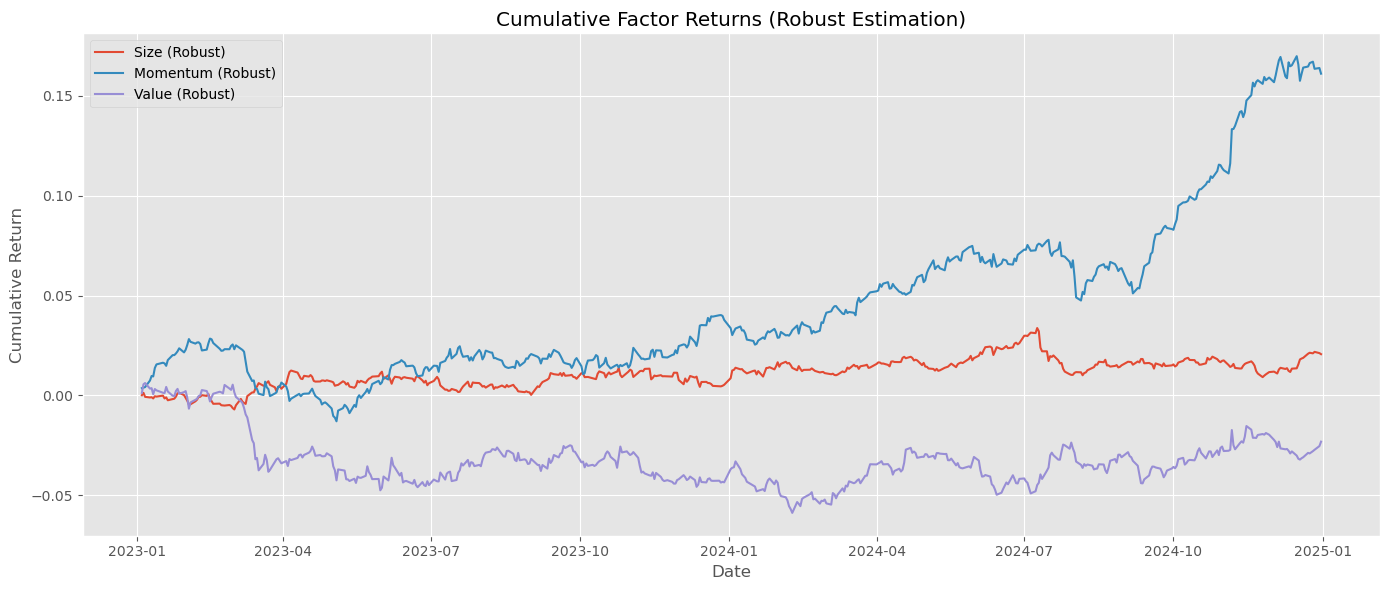

In [7]:
# Plot Size and Momentum for comparison
factors_to_plot = ['Size', 'Momentum', 'Value']

plt.figure(figsize=(14, 6))

for factor in factors_to_plot:
    # We plot the ROBUST version
    cum_ret = (1 + f_ret_robust[factor]).cumprod() - 1
    plt.plot(cum_ret, label=f'{factor} (Robust)')

plt.title("Cumulative Factor Returns (Robust Estimation)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

### 5. Covariance Matrix Estimation
For the optimization in Part 3, we need the **Factor Covariance Matrix**. We calculate it here using the history of factor returns we just generated.

Factor Correlation Matrix:


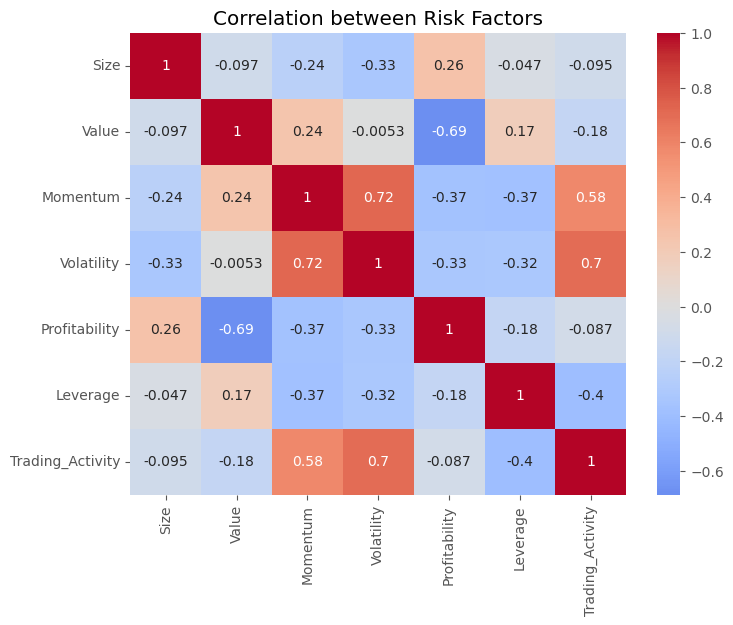

In [8]:
# Calculate covariance of the factor returns (252 annualized scaling)
factor_cov_matrix = f_ret_robust.cov() * 252

print("Factor Correlation Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(f_ret_robust.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between Risk Factors")
plt.show()

# Save covariance for the optimizer
factor_cov_matrix.to_parquet(PROCESSED_DATA_DIR / "factor_covariance.parquet")

In [ ]:
############################################################ END OF FILE ############################################################